In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score



C:\Users\nikit\AppData\Local\Temp\ipykernel_19944\876913482.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the dataset
df = pd.read_csv("air_pollution_data.csv")

# Preprocessing
# Assuming 'dt' is the timestamp column
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)

# Define the sequence length
sequence_length = 10

# Create overlapping sequences and corresponding target sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])  # Target is the next element after the sequence
    return np.array(X), np.array(y)

# Create input sequences and corresponding target sequences
X, y = create_sequences(df.values, sequence_length)

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, sequence_length * X.shape[2])).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)




In [3]:
# Build the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=50, activation='relu', return_sequences=True),  # Add another LSTM layer
    LSTM(units=50, activation='relu'),  # Add another LSTM layer
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')#, metrics=['mae', 'mse', 'mape'])

# Train the model
history=model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)




Epoch 1/50


c:\Users\nikit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1205 - val_loss: 0.1023
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1017 - val_loss: 0.1017
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1010 - val_loss: 0.1014
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1014 - val_loss: 0.1012
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1011 - val_loss: 0.1014
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1006 - val_loss: 0.1009
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1007 - val_loss: 0.1009
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1008 - val_loss: 0.1006
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1005 - val_loss: 0.1005
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1010 - val_loss: 0.1005
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1002 - val_loss: 0.1005
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1001 - val_loss: 0.1004


In [4]:
# Prepare the input data for prediction
# Assuming you want to predict the next  AQI value
num_predictions = 1
input_data = X_test[-1]  # Use the last sequence from the test set as input


# Verify the shape of input_data
print("Shape of input data before reshaping:", input_data.shape)

# Reshape the input data to match the model's input shape
reshaped_input_data = input_data.reshape(1, sequence_length, X.shape[2])
print("Shape of input data after reshaping:", reshaped_input_data.shape)



# Make predictions
predicted_values = []
for _ in range(num_predictions):
    # Predict the next AQI value
    next_prediction = model.predict(reshaped_input_data)[0][0]
    # Store the predicted value
    predicted_values.append(next_prediction)
    # Update the input data for the next prediction
    input_data = np.append(input_data[1:], next_prediction)

# Print the predicted AQI values
print("Predicted AQI values:")
for i, value in enumerate(predicted_values, 1):
    print(f"Prediction {i}: {value*10:.0f}")  #0f to remove decimal point


Shape of input data before reshaping: (10, 9)
Shape of input data after reshaping: (1, 10, 9)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Predicted AQI values:
Prediction 1: 2


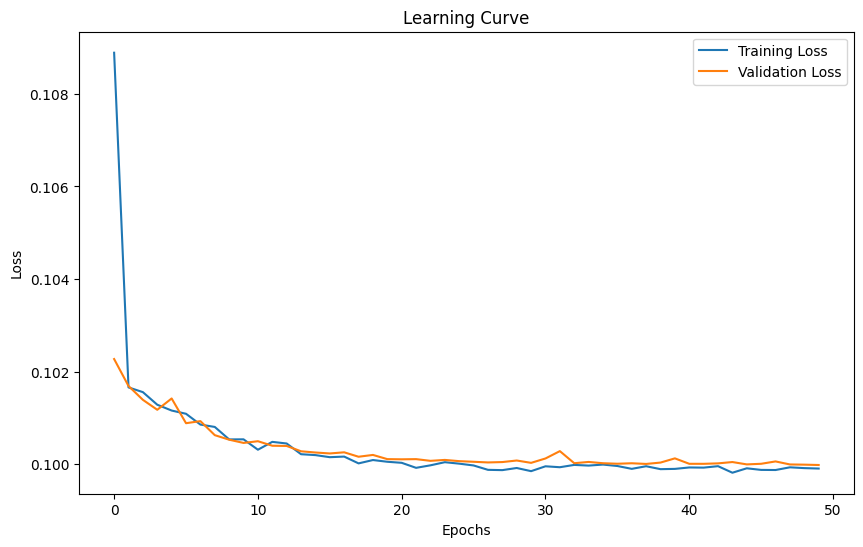

In [5]:
import matplotlib.pyplot as plt

# Get training and validation loss from the model's history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
# Save the model as a .h5 file
model.save("model.h5")

# Save the model as a .pkl file
import joblib
joblib.dump(model, 'model.pkl')

PicklingError: Can't pickle <function Layer._initializer_tracker.<locals>.<lambda> at 0x000002A0A74EB560>: it's not found as keras.src.layers.layer.Layer._initializer_tracker.<locals>.<lambda>